In [0]:
import torch
from torch import nn
from torch import optim
from torch import functional as F
import torch.utils.data
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce

In [0]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=(4,4), stride=(2,2), padding=1, batch_norm=True, relu_slope=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride, bias=not batch_norm)
        self.conv.weight.data.normal_(0, 0.02)
        self.bn = None
        if batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(relu_slope, inplace=True)
    
    def forward(self, X):
        out = self.conv(X)
        if self.bn:
            out = self.bn(out)
        out = self.leaky_relu(out)
        return out

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=(4,4), stride=(2,2), padding=1, dropout=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride, bias=False)
        self.conv.weight.data.normal_(0, 0.02)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = None
        
        if dropout:
            self.dropout = nn.Dropout2d(dropout, inplace=True)
            
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        out = self.conv(X)
        out = self.bn(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.relu(out)
            
        return out
    


    a -------- a
     b ------ b
      c ---- c
       d -- d

    (3, 64) --------------------- (128, 3) # no batch norm
     (64, 128) ----------------- (256, 64)
      (128, 256) -------------- (512, 128)
       (256, 512) ------------ (1024, 256)
        (512, 512) ---------- (1024, 512)
        (512, 512) ---------- (1024, 512) # right have dropout
        (512, 512) ---------- (1024, 512) # right have dropout
         (512, 512) -------- (512, 512) # no batch norm, right have dropout


In [0]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.encoder = nn.ModuleList([
            UNetEncoderBlock(in_channels, 64, batch_norm=False, relu_slope=0.2),
            UNetEncoderBlock(64, 128, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(128, 256, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(256, 512, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=False, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=False, relu_slope=0.2)
        ])
        
        self.decoder = nn.ModuleList([
            UNetDecoderBlock(512, 512, dropout=0.5),
            UNetDecoderBlock(1024, 512, dropout=0.5),
            UNetDecoderBlock(1024, 512, dropout=0.5),
            UNetDecoderBlock(1024, 512),
            UNetDecoderBlock(1024, 256),
            UNetDecoderBlock(512, 128),
            UNetDecoderBlock(256, 64),
            UNetDecoderBlock(128, out_channels),
        ])
        
        self.final = nn.Sequential(nn.Tanh())
        
    def forward(self, X):
        activations = []
        out = X
        # roll the input throught the encoder branch, storing the activations
        for l in self.encoder:
            out = l(out)
            activations.insert(0, out)
        
        out =  self.decoder[0](out)
        
        # execute decoder branch concatenating corresponding encoder activations
        for act, l in zip(activations[1:], self.decoder[1:]):
            out = l(torch.cat([act, out], dim=1))
        
        out = self.final(out)
        return out

# just for syntax sugar
class Generator(UNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

In [0]:
class Discriminator(nn.Sequential):
    _patch_sizes = {
        1: [64, 128],
        16: [64, 128],
        70: [64, 128, 256, 512],
        286: [64, 128, 256, 512, 512, 512]
    }
    
    def requires_grad(self, value):
        for p in self.parameters():
            p.requires_grad = value
    
    def __init__(self, patch_size=70, in_channels=3):
        super().__init__()
        if patch_size not in Discriminator._patch_sizes:
            raise Exception("unkown patch_size, should be one of", list(Discriminator._patch_sizes.keys()))
        
        kernel_size, stride = (4,4), (2,2)
        if patch_size == 1:
            kernel_size = stride = (1,1)
        channels = Discriminator._patch_sizes[patch_size]
        
        layers = [UNetEncoderBlock(in_channels, channels[0], batch_norm=False, relu_slope=0.2)]
        for i, (in_ch, out_ch) in enumerate(zip(channels[:-1], channels[1:])):
            layers.append(UNetEncoderBlock(in_ch, out_ch, batch_norm=i > 0, relu_slope=0.2, kernel=kernel_size, stride=stride))
        
        conv = nn.Conv2d(channels[-1], 1, kernel_size=kernel_size, stride=stride)
        conv.weight.data.normal_(0, 0.02)
        layers.append(conv)
        
        for i, l in enumerate(layers): self.add_module(str(i), l)

In [0]:
batch = np.random.normal(0, 1, (1, 3, 256, 256))

In [0]:
gen = Generator(out_channels=3)
dis = Discriminator(70, in_channels=3+3)

In [0]:
o = gen(torch.from_numpy(batch).float())
dis(torch.cat([o, o], dim=1))

tensor([[[[-1.1302, -0.9206,  0.5013, -1.8061, -0.0121,  1.1000, -2.5302],
          [-1.1317, -1.1814, -0.7326, -0.9276,  0.2450, -0.5238, -1.4000],
          [ 0.6435,  1.1684, -0.6543,  0.3059,  0.8637,  0.1759,  0.2613],
          [ 0.7830, -1.8555, -0.6803, -0.9971, -0.5134,  0.2074,  1.4717],
          [-0.3284, -0.1051,  0.4720, -1.4424,  0.1521,  1.4590, -1.3801],
          [-0.6428,  1.0801,  0.0247,  0.4154, -1.6744, -0.5288, -1.1282],
          [ 0.8721, -0.2246, -1.5472,  0.6098, -0.3027, -3.0849, -0.9070]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [0]:
gen = Generator(out_channels=3)
dis = Discriminator(70, in_channels=3+3)
Gcriterion = optim.Adam(gen.parameters(), lr=0.0002, betas=[0.5, 0.999])
Dcriterion = optim.Adam(dis.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [0]:
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

def loss_gen(X, fake_y, real_y):
    x_fake_y = torch.cat([X, fake_y], dim=1)
    
    pred = dis(x_fake_y)
    target = torch.ones_like(pred)
    loss_fake = bce_loss(pred, target)
    
    l1 = l1_loss(fake_y, real_y)*100
    return loss_fake + l1
    

def loss_dis(X, fake_y, real_y):
    x_fake_y = torch.cat([X, fake_y.detach()], dim=1)
    x_real_y = torch.cat([X, real_y], dim=1)
    
    pred = dis(x_fake_y)
    target = torch.zeros_like(pred)
    loss_fake = bce_loss(pred, target)
    
    pred = dis(x_real_y)
    target = torch.ones_like(pred)
    loss_real = bce_loss(pred, target)
    

    return (loss_fake + loss_real) * 0.5


In [0]:
import cv2
def read_image(path):
    full_img = cv2.imread(path)
    y,x = full_img[:,:256,::-1], full_img[:,256:,::-1]
    return x,y

x,y = read_image("/content/facades/train/10.jpg")

In [0]:
train_filenames = glob("/content/facades/train/**")
test_filenames = glob("/content/facades/test/**")
valid_filenames = glob("/content/facades/val/**")

In [0]:
len(train_filenames), len(test_filenames), len(valid_filenames)

(400, 106, 100)

In [0]:
def filenames2bytes(filenames):
    datas = [read_image(f) for f in filenames]
    x = [a for a,_ in datas]
    y = [b for _,b in datas]
    return np.array(x), np.array(y)
x_train,y_train = filenames2bytes(train_filenames)
x_means,x_stds = x_train.mean(axis=(0,1,2)), x_train.std(axis=(0,1,2))
x_train = (x_train-x_means)/x_stds
y_means,y_stds = y_train.mean(axis=(0,1,2)), y_train.std(axis=(0,1,2))
y_train = (y_train-y_means)/y_stds


x_test,y_test = filenames2bytes(test_filenames)
x_test = (x_test-x_means)/x_stds
y_test = (y_test-y_means)/y_stds

x_valid,y_valid = filenames2bytes(valid_filenames)
x_valid = (x_valid-x_means)/x_stds
y_valid = (y_valid-y_means)/y_stds

In [0]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, idx):
        return self.x[idx].transpose(2, 0, 1), self.y[idx].transpose(2, 0, 1)
    
    def __len__(self): return len(self.x)
    
train_ds = Dataset(x_train, y_train)
test_ds = Dataset(x_test, y_test)
valid_ds = Dataset(x_valid, y_valid)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=32, shuffle=False)

In [0]:
gen = Generator(out_channels=3).cuda()
dis = Discriminator(70, in_channels=3+3).cuda()
Gcriterion = optim.Adam(gen.parameters(), lr=0.0002, betas=[0.5, 0.999])
Dcriterion = optim.Adam(dis.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [0]:
def load_models_data():
  state_data = torch.load("/content/drive/My Drive/pix2pix/20191024_144527_pix2pix.pt")
  gen.load_state_dict(state_data["gen_state_dict"])
  Gcriterion.load_state_dict(state_data["gen_optim"])
  dis.load_state_dict(state_data["dis_state_dict"])
  Dcriterion.load_state_dict(state_data["dis_optim"])
load_models_data()

In [0]:
nums, losses = [], []
for j in range(20):
  print("starting epoch", j)
  for i, (x_batch, y_batch) in enumerate(train_dl):
      x_batch = x_batch.float().cuda()
      y_batch = y_batch.float().cuda()
      
      fake_y = gen(x_batch)
      dis.requires_grad(True)
      Dcriterion.zero_grad()
      l = loss_dis(x_batch, fake_y, y_batch)
      # print("dis", l)
      l.backward()
      Dcriterion.step()
      
      Gcriterion.zero_grad()
      dis.requires_grad(False)
      l = loss_gen(x_batch, fake_y, y_batch)
      # print("gen", l)
      l.backward()
      Gcriterion.step()
      
      # if i >= 10: break
  print("finished epoch", j)

from datetime import datetime
now = datetime.now()
name = now.strftime("%Y%m%d_%H%M%S_pix2pix.pt")
torch.save({
    "gen_state_dict": gen.state_dict(),
    "dis_state_dict": dis.state_dict(),
    "gen_optim": Gcriterion.state_dict(),
    "dis_optim": Dcriterion.state_dict()
}, "/content/drive/My Drive/pix2pix/%s" % str(name))

starting epoch 0
finished epoch 0
starting epoch 1
finished epoch 1
starting epoch 2
finished epoch 2
starting epoch 3
finished epoch 3
starting epoch 4
finished epoch 4
starting epoch 5
finished epoch 5
starting epoch 6
finished epoch 6
starting epoch 7
finished epoch 7
starting epoch 8
finished epoch 8
starting epoch 9
finished epoch 9
starting epoch 10
finished epoch 10
starting epoch 11
finished epoch 11
starting epoch 12
finished epoch 12
starting epoch 13
finished epoch 13
starting epoch 14
finished epoch 14
starting epoch 15
finished epoch 15
starting epoch 16
finished epoch 16
starting epoch 17
finished epoch 17
starting epoch 18
finished epoch 18
starting epoch 19
finished epoch 19


In [0]:
x,y = test_ds[9]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


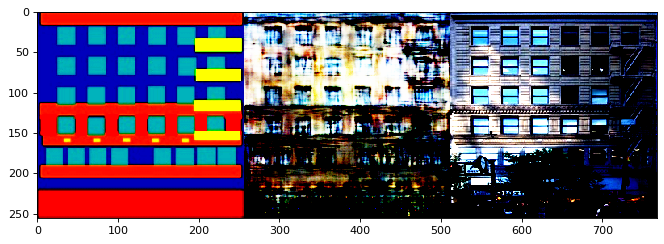

In [0]:
plt.figure(figsize=(10,4), dpi=80)
fake_im_t = gen.cuda()(torch.from_numpy(x.reshape(-1, 3, 256, 256)).float().cuda()).detach()
fake_im = fake_im_t.cpu().numpy()[0]
plt.imshow(np.concatenate([x.transpose(1, 2, 0), fake_im.transpose(1, 2, 0), y.transpose(1, 2, 0), ], axis=1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


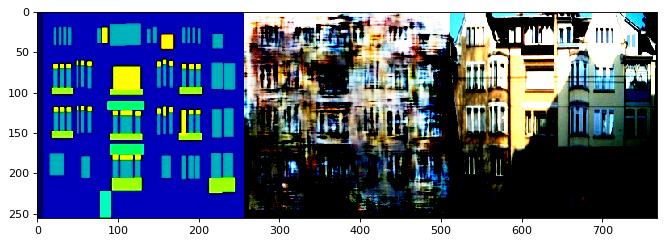

In [0]:
plt.figure(figsize=(10,4), dpi=80)
fake_im_t = gen.cuda()(torch.from_numpy(x.reshape(-1, 3, 256, 256)).float().cuda()).detach()
fake_im = fake_im_t.cpu().numpy()[0]
plt.imshow(np.concatenate([x.transpose(1, 2, 0), fake_im.transpose(1, 2, 0), y.transpose(1, 2, 0)], axis=1))


In [0]:
x_t = torch.from_numpy(x[None,...]).float().cuda()
y_t = torch.from_numpy(y[None,...]).float().cuda()
torch.sigmoid(dis(torch.cat([x_t, fake_im_t], dim=1)))
# torch.sigmoid(dis(torch.cat([x_t, y_t], dim=1)))

tensor([[[[5.4995e-07, 6.1214e-07, 4.1578e-07, 2.6647e-07, 5.5195e-07,
           9.9322e-07, 2.6736e-07],
          [9.9309e-07, 5.1621e-07, 5.4045e-07, 4.9281e-07, 1.1819e-06,
           9.7273e-07, 3.1640e-07],
          [5.0354e-07, 7.3166e-07, 7.2740e-07, 6.5939e-07, 8.5545e-07,
           9.2812e-07, 2.6471e-07],
          [5.6091e-07, 2.5015e-07, 1.0255e-06, 1.6953e-06, 3.1296e-06,
           9.1542e-07, 6.2520e-07],
          [8.6654e-07, 9.9367e-07, 1.3662e-06, 1.8990e-06, 2.1993e-06,
           2.4515e-06, 3.9326e-07],
          [1.1721e-06, 1.7461e-06, 2.0991e-06, 1.2026e-06, 1.0487e-06,
           2.3386e-06, 9.3180e-07],
          [3.8487e-07, 4.5660e-07, 4.8586e-07, 3.1483e-07, 7.5663e-07,
           1.1362e-06, 2.8584e-07]]]], device='cuda:0')

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')